# Download Data

In [2]:
import requests
import pandas as pd
from io import BytesIO

def download_csv(csv_url):
    response = requests.get(csv_url)
    response.raise_for_status()

    # Qui puoi modificare 'sep' o aggiungere altri parametri se necessario
    try:
        df = pd.read_csv(BytesIO(response.content), sep=',')
    except pd.errors.ParserError:
        df = pd.read_csv(BytesIO(response.content), sep=';', error_bad_lines=False)

    return df

In [4]:
recipes_df = download_csv("https://media.githubusercontent.com/media/DonatoFe11/SustainaMeal_Case_Study/master/data/final_recipes_set.csv")

In [5]:
recipes_df

,title,sustainability_score,sustainability_label,Unnamed: 0,recipe_id,description,author_id,duration,directions,ingredients,...,protein [g],direction_size,ingredients_sizes,who_score,fsa_score,nutri_score,normalization_comment,ingredient_food_kg_urls,ingredient_food_kg_names,healthiness_label
0,Boiled Radishes,0.002502,0,294268,179840,These taste a lot like new potatoes. The boil...,254469,22.0,"['Trim ends and bad spots off Radishes.', 'Boi...","['radishes size bag bunch', 'water radishes']",...,0.8,2,2,0.293040,1.000,0.75,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['applesauce', 'garlic clove', 'ginger', 'mola...",0
1,Apple Cider Reduction,0.002623,0,59722,521756,I saw a post about this on Facebook and gave i...,171084,155.0,"['In 6-8 quart stock pan, measure out 2 cups o...","['gallon apple cider fresh', 'gallon apple cid...",...,0.0,10,2,0.214286,0.750,0.75,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['bean sprouts', 'chicken thighs', 'fresh ging...",1
2,Homemade Apple Pectin Stock,0.002623,0,159910,25188,Easy to make and works well.,10404,25.0,['Slice unpeeled apples including cores and se...,"['tart apple', 'water pound apples']",...,1.2,11,2,0.278414,0.750,0.75,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['baking powder', 'baking soda', 'cinnamon', '...",0
3,Easy Applesauce,0.002623,0,421226,264179,Use fresh cooking apples for this for best res...,37636,50.0,['Place apples and cider into a large saucepan...,"['apples', 'apple cider']",...,0.5,3,2,0.276525,0.875,0.75,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['carrots', 'fresh peas', 'fresh tomatoes', 'g...",0
4,Cider Baked Sausage,0.002752,0,374088,101966,A very easy to make main dish perfect for fall...,30534,50.0,"['Preheat oven to 350°.', 'Prick sausages with...","['breakfast sausage links', 'apples Smith', 'o...",...,46.4,4,4,0.146714,0.125,0.00,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['Shedd Spread Country Crock', 'cayenne pepper...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93743,Curried Lamb on Rice,0.951024,2,103145,373244,"With modification this recipe is from ""The Dia...",133174,65.0,"['Over medium heat, melt the butter in a large...","['lamb', 'medium onion', 'cloves', 'butter', '...",...,28.7,5,13,0.223549,0.625,0.25,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['Dijon mustard', 'Polish sausage', 'apricot p...",1
93744,Rich Lamb Curry,0.960504,2,442694,268247,The recipe isn't as time consuming as it looks...,491437,110.0,"['Heat 1 tbsp olive oil in dutch oven. ', 'Co...","['oil', 'lamb', 'flour', 'salt pepper', 'onion...",...,36.1,9,21,0.153328,0.000,0.00,NaN,NaN,NaN,1
93745,"Middle Eastern Slow-Cooked Stew With Lamb, Chi...",0.968458,2,359960,144850,From Cooking Light. Per 3/4 c. serving: 310 ca...,37779,112.0,['Let the oil get heating in a large pot over ...,"['oil', 'lamb', 'onions rings', 'water', 'clov...",...,20.8,12,19,0.205566,0.250,0.25,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"['anchovies', 'celery ribs', 'diced tomatoes',...",1
93746,Five Meat Chili Con Carne With Beans,0.971454,2,37637,13568,yum,20571,210.0,"['In a large pot brown meat in stages, about a...","['beef', 'pork', 'lamb', 'sausage', 'sausage',...",...,14.5,7,15,0.197568,0.250,0.25,NaN,['http://idea.rpi.edu/heals/kb/ingredientname/...,"[""French\\'s French fried onions"", 'crabmeat',...",1


# SustainaMeal (ETA: 15/20 mins)

Initializes the system by loading the data and preparing the embeddings.

In [17]:
from HeASe.sustainameal import SustainaMeal

nutrients = ['calories [cal]', 'totalFat [g]', 'sodium [mg]', 'dietaryFiber [g]', 'sugars [g]', 'protein [g]']
#nutrients = ['calories [cal]', 'totalFat [g]', 'saturatedFat [g]', 'cholesterol [mg]', 'sodium [mg]', 'dietaryFiber [g]', 'sugars [g]', 'protein [g]']

sm = SustainaMeal(
    recipes_df=recipes_df,
    nutrients=['calories [cal]', 'totalFat [g]', 'sodium [mg]', 'dietaryFiber [g]', 'sugars [g]', 'protein [g]'],
    transformer_name='davanstrien/autotrain-recipes-2451975973'
)

Processing Titles embeddings: 100%|██████████| 93748/93748 [18:57<00:00, 82.43batch/s]


# Experiments

In [18]:
import pandas as pd
import ast
import json
from collections import Counter
# Supponiamo che recipes_df sia il tuo DataFrame originale con tutte le ricette

# Calcola la media di who_score
mean_who_score = recipes_df['who_score'].mean()

acceptable_tags = ['appetizers', 'main-dish', 'side-dishes', 'drinks', 'beverages', 'fruits', 'desserts',
                   'breakfast', 'pasta-rice-and-grains', 'rice', 'pasta', 'pizza', 'breads', 'meat', 'fish',
                   'seafood', 'beef', 'chicken', 'vegetarian']

def has_acceptable_tag(tags_str):
    try:
        # Converte la stringa in una lista
        tags = ast.literal_eval(tags_str)
    except (ValueError, SyntaxError):
        # Gestisce eventuali errori nella conversione
        tags = []
    # Controlla se almeno un tag è in acceptable_tags
    return any(tag in acceptable_tags for tag in tags)

# Inizializza un set vuoto per tenere traccia degli ID delle ricette già selezionati
selected_recipe_ids = set()

# Funzione per selezionare ricette uniche da un DataFrame
def select_unique_recipes(df, count=100):
    global selected_recipe_ids
    unique_df = df[~df['recipe_id'].isin(selected_recipe_ids)].sample(min(count, len(df)))
    selected_recipe_ids.update(unique_df['recipe_id'])
    return unique_df

# Filtra le ricette con un who_score superiore alla media e almeno un tag accettabile
high_who_score_recipes = select_unique_recipes(recipes_df[(recipes_df['who_score'] > mean_who_score) &
                                                          (recipes_df['tags'].apply(has_acceptable_tag))])

# Filtra le ricette con sustainability_label = 1 e almeno un tag accettabile
sustainability_label_1_recipes = select_unique_recipes(recipes_df[(recipes_df['sustainability_label'] == 1) &
                                                                  (recipes_df['tags'].apply(has_acceptable_tag))])

# Filtra le ricette con sustainability_label = 2 e almeno un tag accettabile
sustainability_label_2_recipes = select_unique_recipes(recipes_df[(recipes_df['sustainability_label'] == 2) &
                                                                  (recipes_df['tags'].apply(has_acceptable_tag))])

# Unisci le ricette selezionate
selected_recipes = pd.concat([high_who_score_recipes, sustainability_label_1_recipes, sustainability_label_2_recipes])


In [8]:
high_who_score_recipes_file = '../experiments/data/high_who_score_recipes.json'
sustainability_label_1_recipes_file = '../experiments/data/sustainability_label_1_recipes.json'
sustainability_label_2_recipes_file = '../experiments/data/sustainability_label_2_recipes.json'

# Read the JSON files into pandas DataFrames
high_who_score_recipes = pd.read_json(high_who_score_recipes_file)
sustainability_label_1_recipes = pd.read_json(sustainability_label_1_recipes_file)
sustainability_label_2_recipes = pd.read_json(sustainability_label_2_recipes_file)
selected_recipes = pd.concat([high_who_score_recipes, sustainability_label_1_recipes, sustainability_label_2_recipes])

In [19]:
len(selected_recipes)

300

In [20]:
nutrients_string = ", ".join(nutrients)
print(nutrients_string)

calories [cal], totalFat [g], sodium [mg], dietaryFiber [g], sugars [g], protein [g]


In [10]:
results = []

In [21]:
# Parametri per gli esperimenti
k_values = [1, 10, 50, 100]
match_all_tags_values = [True, False]

def convert_to_serializable(obj):
    """
    Converte oggetti in formati serializzabili in JSON.
    Gestisce DataFrame, array NumPy e altri tipi non serializzabili.
    """
    if hasattr(obj, 'to_dict'):
        # Converti il DataFrame pandas in un dizionario
        return obj.to_dict('records')
    elif hasattr(obj, 'tolist'):
        # Converti l'array NumPy in una lista
        return obj.tolist()
    elif isinstance(obj, (list, dict, str, int, float, bool, type(None))):
        # Tipi già serializzabili in JSON
        return obj
    else:
        # Converti altri tipi in stringa o implementa altre conversioni
        return str(obj)



for index, row in selected_recipes.iterrows():
    input_recipe = row['title']
    for k in k_values:
        for match_all_tags in match_all_tags_values:
            similar_recipes = sm.find_similar_recipes(input_recipe, k, acceptable_tags, match_all_tags=match_all_tags)
            recipe_by_sustainameal_score = sm.order_recipe_by_sustainameal()

            result = {
                'recipe_name': input_recipe,
                'recipe_id': row['recipe_id'],
                'sustnability_score': 1-row['sustainability_score'],
                'sustnability_label': row['sustainability_label'],
                'who_score': row['who_score'],
                'healthiness_label': row['healthiness_label'],
                'k': k,
                'nutrients' : nutrients_string,
                'match_all_tags': match_all_tags,
                'similar_recipes': convert_to_serializable(similar_recipes),
                'ordered_by_sustainameal': convert_to_serializable(recipe_by_sustainameal_score[:10])
            }
            results.append(result)


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.49batch/s]

Tags to match: ['appetizers', 'chicken', 'meat']
Number of filtered recipes: 317


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.61batch/s]


Tags to match: ['appetizers', 'chicken', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.83batch/s]


Tags to match: ['appetizers', 'chicken', 'meat']
Number of filtered recipes: 317


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.59batch/s]


Tags to match: ['appetizers', 'chicken', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.98batch/s]


Tags to match: ['appetizers', 'chicken', 'meat']
Number of filtered recipes: 317


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.27batch/s]


Tags to match: ['appetizers', 'chicken', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.38batch/s]


Tags to match: ['appetizers', 'chicken', 'meat']
Number of filtered recipes: 317


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.37batch/s]


Tags to match: ['appetizers', 'chicken', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.66batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 652


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.55batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 27761


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.05batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 652


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.65batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 27761


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.04batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 652


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.33batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 27761


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.65batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 652


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.01batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 27761


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.58batch/s]


Tags to match: ['pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 2832


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.43batch/s]


Tags to match: ['pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 24314


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.32batch/s]


Tags to match: ['pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 2832


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.47batch/s]


Tags to match: ['pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 24314


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.70batch/s]


Tags to match: ['pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 2832


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.12batch/s]


Tags to match: ['pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 24314


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.28batch/s]


Tags to match: ['pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 2832


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.61batch/s]


Tags to match: ['pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 24314


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.29batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.83batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.11batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.73batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.13batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.85batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.36batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.92batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.19batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.52batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.43batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.77batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.42batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.55batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.94batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.84batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.09batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.45batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.10batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.01batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.04batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.98batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.94batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.48batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.48batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.93batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.02batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.13batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.07batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.10batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.70batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.69batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.95batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.16batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.49batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.48batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.72batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.10batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.08batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.39batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.17batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.80batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.29batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.82batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.41batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.45batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.22batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.88batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.78batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 3683


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.49batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 23738


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.83batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 3683


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.38batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 23738


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.57batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 3683


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.31batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 23738


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.65batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 3683


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.52batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 23738


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.68batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 1223


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.68batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 40632


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.32batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 1223


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.59batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 40632


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.79batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 1223


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.04batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 40632


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.01batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 1223


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.65batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 40632


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.08batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.54batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.25batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.51batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.70batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.64batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.50batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.97batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.31batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.44batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.68batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.59batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.12batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.57batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.41batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.62batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.01batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.28batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.60batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.00batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.61batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.21batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.22batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.13batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.33batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.50batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.11batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.02batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.47batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.92batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.46batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.61batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.59batch/s]


Tags to match: ['breakfast', 'main-dish', 'vegetarian']
Number of filtered recipes: 98


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.09batch/s]


Tags to match: ['breakfast', 'main-dish', 'vegetarian']
Number of filtered recipes: 41474


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.96batch/s]


Tags to match: ['breakfast', 'main-dish', 'vegetarian']
Number of filtered recipes: 98


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.80batch/s]


Tags to match: ['breakfast', 'main-dish', 'vegetarian']
Number of filtered recipes: 41474


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.94batch/s]


Tags to match: ['breakfast', 'main-dish', 'vegetarian']
Number of filtered recipes: 98


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.66batch/s]


Tags to match: ['breakfast', 'main-dish', 'vegetarian']
Number of filtered recipes: 41474


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.55batch/s]


Tags to match: ['breakfast', 'main-dish', 'vegetarian']
Number of filtered recipes: 98


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.60batch/s]


Tags to match: ['breakfast', 'main-dish', 'vegetarian']
Number of filtered recipes: 41474


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.25batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.55batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.67batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.35batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.10batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.11batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.78batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.65batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.83batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.45batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.50batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.55batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.50batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.04batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.33batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.87batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.57batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.64batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.44batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.90batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.09batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.28batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.44batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.69batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.85batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.69batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.48batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.01batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.49batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.86batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.27batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.72batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.52batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 3683


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.14batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 23738


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.68batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 3683


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.57batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 23738


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.45batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 3683


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.71batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 23738


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.25batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 3683


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.46batch/s]


Tags to match: ['side-dishes', 'vegetarian']
Number of filtered recipes: 23738


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.60batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.25batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.25batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.94batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.91batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.00batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.98batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.30batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.30batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.43batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.01batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.74batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.22batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.13batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.29batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.08batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.97batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.96batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.63batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.61batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.48batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.65batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.15batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.84batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.83batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.40batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.23batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.36batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.91batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.28batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.89batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.25batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 1560


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.83batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 35671


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.93batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 1560


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.37batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 35671


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.52batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 1560


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.84batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 35671


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.80batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 1560


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.19batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 35671


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.56batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.27batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.26batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.85batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.47batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.98batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.98batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.72batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.49batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.49batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.28batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.89batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.79batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.99batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.15batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.94batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.02batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.81batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.25batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.93batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.96batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.33batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.34batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.62batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.11batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.82batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.27batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.94batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.54batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.75batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.84batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.57batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.72batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.75batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.38batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.36batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.88batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.62batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.37batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.75batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.15batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.45batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.65batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.95batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.47batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.26batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.07batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.73batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.82batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.42batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.35batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.29batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.89batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.23batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.52batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.40batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.86batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.01batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.10batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.66batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.24batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.10batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.35batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.81batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.62batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.81batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.72batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.96batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.87batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.78batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.84batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.29batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.45batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 219


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.74batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 19185


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.54batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 219


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.40batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 19185


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.40batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 219


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.74batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 19185


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.71batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 219


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.45batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 19185


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.63batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.90batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.98batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.01batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.06batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.53batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.95batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.30batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.31batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.77batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.01batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.02batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.37batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.84batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.01batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.77batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.34batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.74batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.27batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.13batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.82batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.76batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.72batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.72batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.18batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.08batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.17batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.38batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.46batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.33batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.95batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.71batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.11batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.26batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.36batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.89batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.02batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.09batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.47batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.00batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 47.94batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.04batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.60batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.63batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.08batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.93batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.45batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.94batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.74batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 1223


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.52batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 40632


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.22batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 1223


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.24batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 40632


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.22batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 1223


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.99batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 40632


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.84batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 1223


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.33batch/s]


Tags to match: ['main-dish', 'pasta', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 40632


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.50batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.49batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.31batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.19batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.80batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.64batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.15batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.83batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.65batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.43batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.63batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.95batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.44batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.43batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.12batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.67batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 46.86batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.44batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.29batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.83batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.20batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.30batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.14batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.14batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.83batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.98batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.70batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.78batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.24batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.68batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.61batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.42batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.26batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.60batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.38batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.69batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.48batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.93batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.32batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.38batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.40batch/s]


Tags to match: ['main-dish', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.15batch/s]


Tags to match: ['main-dish', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 30435


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.41batch/s]


Tags to match: ['main-dish', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.02batch/s]


Tags to match: ['main-dish', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 30435


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.10batch/s]


Tags to match: ['main-dish', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.53batch/s]


Tags to match: ['main-dish', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 30435


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.17batch/s]


Tags to match: ['main-dish', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.94batch/s]


Tags to match: ['main-dish', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 30435


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.69batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.94batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.29batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.48batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.51batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.04batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.51batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.27batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.26batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.15batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.83batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.93batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.58batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.99batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.37batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.43batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.16batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.35batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.37batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.99batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.36batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.82batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.17batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.36batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.29batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.49batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.22batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.40batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.62batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.64batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.22batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.31batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.09batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.57batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.82batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.95batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.03batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.05batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.08batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.23batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.89batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.83batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.68batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.23batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.34batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.41batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.18batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.28batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.26batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.84batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.61batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.31batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.20batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.85batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.30batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.10batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.67batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.94batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.67batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.69batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.06batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.30batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.04batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.96batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.61batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.07batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.46batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.41batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.77batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.46batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.06batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.54batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.74batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.94batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.89batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.29batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.09batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.72batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.41batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.51batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.01batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.22batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.88batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.87batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.59batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.06batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.94batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.89batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.00batch/s]


Tags to match: ['seafood', 'fish']
Number of filtered recipes: 5070


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.34batch/s]


Tags to match: ['seafood', 'fish']
Number of filtered recipes: 5288


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.56batch/s]


Tags to match: ['seafood', 'fish']
Number of filtered recipes: 5070


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.18batch/s]


Tags to match: ['seafood', 'fish']
Number of filtered recipes: 5288


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.75batch/s]


Tags to match: ['seafood', 'fish']
Number of filtered recipes: 5070


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.97batch/s]


Tags to match: ['seafood', 'fish']
Number of filtered recipes: 5288


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.25batch/s]


Tags to match: ['seafood', 'fish']
Number of filtered recipes: 5070


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.42batch/s]


Tags to match: ['seafood', 'fish']
Number of filtered recipes: 5288


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.25batch/s]


Tags to match: ['breads', 'meat']
Number of filtered recipes: 103


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.93batch/s]


Tags to match: ['breads', 'meat']
Number of filtered recipes: 24283


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.69batch/s]


Tags to match: ['breads', 'meat']
Number of filtered recipes: 103


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 45.61batch/s]


Tags to match: ['breads', 'meat']
Number of filtered recipes: 24283


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.28batch/s]


Tags to match: ['breads', 'meat']
Number of filtered recipes: 103


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.50batch/s]


Tags to match: ['breads', 'meat']
Number of filtered recipes: 24283


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.21batch/s]


Tags to match: ['breads', 'meat']
Number of filtered recipes: 103


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.77batch/s]


Tags to match: ['breads', 'meat']
Number of filtered recipes: 24283


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.61batch/s]


Tags to match: ['breakfast', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 312


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.84batch/s]


Tags to match: ['breakfast', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 29247


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.72batch/s]


Tags to match: ['breakfast', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 312


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.26batch/s]


Tags to match: ['breakfast', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 29247


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.90batch/s]


Tags to match: ['breakfast', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 312


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.10batch/s]


Tags to match: ['breakfast', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 29247


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.09batch/s]


Tags to match: ['breakfast', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 312


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.64batch/s]


Tags to match: ['breakfast', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 29247


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.61batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.30batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.66batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.36batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.92batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.35batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.11batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.27batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.79batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.61batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.13batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.58batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.42batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.82batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.41batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.75batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.62batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.11batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.48batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.41batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.54batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.37batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.51batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.42batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.38batch/s]


Tags to match: ['breads', 'vegetarian']
Number of filtered recipes: 1011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.80batch/s]


Tags to match: ['breads', 'vegetarian']
Number of filtered recipes: 20812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.18batch/s]


Tags to match: ['breads', 'vegetarian']
Number of filtered recipes: 1011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.98batch/s]


Tags to match: ['breads', 'vegetarian']
Number of filtered recipes: 20812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.50batch/s]


Tags to match: ['breads', 'vegetarian']
Number of filtered recipes: 1011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.33batch/s]


Tags to match: ['breads', 'vegetarian']
Number of filtered recipes: 20812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 47.96batch/s]


Tags to match: ['breads', 'vegetarian']
Number of filtered recipes: 1011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.38batch/s]


Tags to match: ['breads', 'vegetarian']
Number of filtered recipes: 20812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.66batch/s]


Tags to match: ['main-dish', 'pasta', 'seafood', 'pasta-rice-and-grains']
Number of filtered recipes: 760


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.04batch/s]


Tags to match: ['main-dish', 'pasta', 'seafood', 'pasta-rice-and-grains']
Number of filtered recipes: 32171


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.43batch/s]


Tags to match: ['main-dish', 'pasta', 'seafood', 'pasta-rice-and-grains']
Number of filtered recipes: 760


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.66batch/s]


Tags to match: ['main-dish', 'pasta', 'seafood', 'pasta-rice-and-grains']
Number of filtered recipes: 32171


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.00batch/s]


Tags to match: ['main-dish', 'pasta', 'seafood', 'pasta-rice-and-grains']
Number of filtered recipes: 760


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.51batch/s]


Tags to match: ['main-dish', 'pasta', 'seafood', 'pasta-rice-and-grains']
Number of filtered recipes: 32171


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.44batch/s]


Tags to match: ['main-dish', 'pasta', 'seafood', 'pasta-rice-and-grains']
Number of filtered recipes: 760


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.58batch/s]


Tags to match: ['main-dish', 'pasta', 'seafood', 'pasta-rice-and-grains']
Number of filtered recipes: 32171


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.83batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.09batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.58batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.73batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.39batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.15batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.13batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.25batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.39batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.83batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.80batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.83batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.56batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.62batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.69batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.86batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.42batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.48batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.31batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.89batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.32batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.70batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 47.55batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.49batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.99batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.74batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.36batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 43.13batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.97batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.41batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.64batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.99batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.38batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.53batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.87batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.37batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.77batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.58batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.78batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.57batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.81batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.94batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.17batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.07batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.75batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.07batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.48batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.23batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.06batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.56batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.72batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.40batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.35batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.37batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.96batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.62batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.02batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.79batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.89batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.12batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.32batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.10batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.72batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.66batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.64batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.56batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.32batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.04batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.30batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 48.09batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.79batch/s]


Tags to match: ['beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 939


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.52batch/s]


Tags to match: ['beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 26858


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.01batch/s]


Tags to match: ['beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 939


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.37batch/s]


Tags to match: ['beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 26858


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.99batch/s]


Tags to match: ['beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 939


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.56batch/s]


Tags to match: ['beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 26858


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.26batch/s]


Tags to match: ['beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 939


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.92batch/s]


Tags to match: ['beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 26858


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.51batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 3361


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.41batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.37batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 3361


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.38batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.41batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 3361


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.45batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.54batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 3361


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.91batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.07batch/s]


Tags to match: ['main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 734


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.52batch/s]


Tags to match: ['main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 39608


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.79batch/s]


Tags to match: ['main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 734


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.49batch/s]


Tags to match: ['main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 39608


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.39batch/s]


Tags to match: ['main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 734


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.48batch/s]


Tags to match: ['main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 39608


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.54batch/s]


Tags to match: ['main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 734


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.32batch/s]


Tags to match: ['main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 39608


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.25batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.06batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.51batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.32batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.40batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.73batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.21batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.56batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.70batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.39batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.52batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.65batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.87batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.53batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.29batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.86batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.77batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.71batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.82batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.91batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.33batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.91batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.20batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.79batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.74batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.44batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.39batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.49batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.06batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.09batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.82batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.53batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.11batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.68batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.36batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.39batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 48.85batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.97batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.10batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.91batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.32batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.73batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.11batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.17batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.30batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.55batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.66batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.65batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.58batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.66batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.51batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.21batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.18batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.14batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.59batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.62batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.41batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.02batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.25batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.72batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.41batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.15batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.69batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.18batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.55batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.49batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.93batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.65batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.72batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.30batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 48.23batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.59batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.40batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.04batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.25batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.29batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.90batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.10batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.52batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.85batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.74batch/s]


Tags to match: ['breakfast', 'vegetarian']
Number of filtered recipes: 1341


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.74batch/s]


Tags to match: ['breakfast', 'vegetarian']
Number of filtered recipes: 20266


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.00batch/s]


Tags to match: ['breakfast', 'vegetarian']
Number of filtered recipes: 1341


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.21batch/s]


Tags to match: ['breakfast', 'vegetarian']
Number of filtered recipes: 20266


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.75batch/s]


Tags to match: ['breakfast', 'vegetarian']
Number of filtered recipes: 1341


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.69batch/s]


Tags to match: ['breakfast', 'vegetarian']
Number of filtered recipes: 20266


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.42batch/s]


Tags to match: ['breakfast', 'vegetarian']
Number of filtered recipes: 1341


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.18batch/s]


Tags to match: ['breakfast', 'vegetarian']
Number of filtered recipes: 20266


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.97batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.24batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.00batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.21batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.89batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.88batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.13batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.01batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.14batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.70batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.56batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.54batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.11batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.49batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.52batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.42batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.26batch/s]


Tags to match: ['main-dish', 'side-dishes', 'vegetarian']
Number of filtered recipes: 624


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.41batch/s]


Tags to match: ['main-dish', 'side-dishes', 'vegetarian']
Number of filtered recipes: 44417


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.22batch/s]


Tags to match: ['main-dish', 'side-dishes', 'vegetarian']
Number of filtered recipes: 624


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.86batch/s]


Tags to match: ['main-dish', 'side-dishes', 'vegetarian']
Number of filtered recipes: 44417


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.76batch/s]


Tags to match: ['main-dish', 'side-dishes', 'vegetarian']
Number of filtered recipes: 624


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.63batch/s]


Tags to match: ['main-dish', 'side-dishes', 'vegetarian']
Number of filtered recipes: 44417


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.01batch/s]


Tags to match: ['main-dish', 'side-dishes', 'vegetarian']
Number of filtered recipes: 624


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.28batch/s]


Tags to match: ['main-dish', 'side-dishes', 'vegetarian']
Number of filtered recipes: 44417


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.66batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.13batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.42batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.74batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.57batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.52batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.01batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.99batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.83batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.65batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.86batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.94batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.55batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.55batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.16batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.16batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.25batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.70batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.41batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.18batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.05batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.93batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.76batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.90batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.39batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.93batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.54batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.04batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.79batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.88batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.56batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.01batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.80batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.18batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.96batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.98batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.00batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.83batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.80batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.22batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.99batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.13batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.10batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.95batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.28batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.21batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.36batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 47.31batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.46batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.69batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.86batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.14batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.98batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.05batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.31batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.20batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.59batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.92batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.21batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.55batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.64batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.51batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.47batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.11batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.57batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.32batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.48batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.34batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.77batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.13batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.68batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.51batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.05batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.54batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.16batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.66batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.49batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.74batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.44batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.99batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.48batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.07batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.42batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.35batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.00batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.63batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.71batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.36batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.61batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.33batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.30batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.87batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.99batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.65batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.54batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.17batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.10batch/s]


Tags to match: ['breads', 'breakfast']
Number of filtered recipes: 1373


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.03batch/s]


Tags to match: ['breads', 'breakfast']
Number of filtered recipes: 12433


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.61batch/s]


Tags to match: ['breads', 'breakfast']
Number of filtered recipes: 1373


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.03batch/s]


Tags to match: ['breads', 'breakfast']
Number of filtered recipes: 12433


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.08batch/s]


Tags to match: ['breads', 'breakfast']
Number of filtered recipes: 1373


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 80.27batch/s]


Tags to match: ['breads', 'breakfast']
Number of filtered recipes: 12433


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.15batch/s]


Tags to match: ['breads', 'breakfast']
Number of filtered recipes: 1373


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.01batch/s]


Tags to match: ['breads', 'breakfast']
Number of filtered recipes: 12433


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.46batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.26batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.97batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.67batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.94batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.42batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.69batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.04batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.54batch/s]


Tags to match: ['appetizers', 'main-dish']
Number of filtered recipes: 699


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.00batch/s]


Tags to match: ['appetizers', 'main-dish']
Number of filtered recipes: 30976


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.87batch/s]


Tags to match: ['appetizers', 'main-dish']
Number of filtered recipes: 699


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.72batch/s]


Tags to match: ['appetizers', 'main-dish']
Number of filtered recipes: 30976


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.65batch/s]


Tags to match: ['appetizers', 'main-dish']
Number of filtered recipes: 699


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.46batch/s]


Tags to match: ['appetizers', 'main-dish']
Number of filtered recipes: 30976


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.51batch/s]


Tags to match: ['appetizers', 'main-dish']
Number of filtered recipes: 699


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.79batch/s]


Tags to match: ['appetizers', 'main-dish']
Number of filtered recipes: 30976


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.56batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.08batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.53batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.46batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.02batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.02batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.17batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.71batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.99batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.65batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.83batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.11batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.15batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.29batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.80batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.43batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.22batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.76batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.89batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.77batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.85batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.42batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.40batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.96batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.55batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.68batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.36batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.31batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.17batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.08batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.38batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.92batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.20batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.19batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.96batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.33batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.86batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.80batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.70batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.20batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.63batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.99batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.63batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.98batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.22batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.65batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.24batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.04batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.81batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.98batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.47batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.11batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.77batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.31batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.56batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.22batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.38batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.00batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.74batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.16batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.39batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.23batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.23batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.62batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.93batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.60batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.36batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.67batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.12batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.05batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.78batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.74batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.00batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.47batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.68batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.11batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.74batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.96batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.87batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.19batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.60batch/s]


Tags to match: ['breads', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 263


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.41batch/s]


Tags to match: ['breads', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 29810


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.05batch/s]


Tags to match: ['breads', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 263


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.06batch/s]


Tags to match: ['breads', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 29810


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.79batch/s]


Tags to match: ['breads', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 263


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.17batch/s]


Tags to match: ['breads', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 29810


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.65batch/s]


Tags to match: ['breads', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 263


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.64batch/s]


Tags to match: ['breads', 'vegetarian', 'pasta-rice-and-grains']
Number of filtered recipes: 29810


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.36batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.21batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.55batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.23batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.21batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.15batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.61batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.19batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.31batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 219


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.49batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 19185


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.48batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 219


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.87batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 19185


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.68batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 219


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.40batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 19185


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.30batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 219


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.03batch/s]


Tags to match: ['breakfast', 'side-dishes']
Number of filtered recipes: 19185


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.65batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.41batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.23batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.68batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.70batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.99batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.26batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.01batch/s]


Tags to match: ['vegetarian']
Number of filtered recipes: 14812


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.01batch/s]


Tags to match: ['breakfast', 'meat']
Number of filtered recipes: 546


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.01batch/s]


Tags to match: ['breakfast', 'meat']
Number of filtered recipes: 23624


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.83batch/s]


Tags to match: ['breakfast', 'meat']
Number of filtered recipes: 546


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.05batch/s]


Tags to match: ['breakfast', 'meat']
Number of filtered recipes: 23624


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.22batch/s]


Tags to match: ['breakfast', 'meat']
Number of filtered recipes: 546


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.70batch/s]


Tags to match: ['breakfast', 'meat']
Number of filtered recipes: 23624


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.90batch/s]


Tags to match: ['breakfast', 'meat']
Number of filtered recipes: 546


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.18batch/s]


Tags to match: ['breakfast', 'meat']
Number of filtered recipes: 23624


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.16batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 862


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.79batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 11479


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.62batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 862


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.37batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 11479


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.07batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 862


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.49batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 11479


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.36batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 862


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.06batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 11479


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.58batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.78batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.46batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.26batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.36batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.21batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.17batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.55batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.00batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.27batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.27batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.65batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.50batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.72batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.53batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.93batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.06batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.53batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.97batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.78batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.03batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.55batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.50batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.65batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.57batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.10batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.79batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.27batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.58batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.69batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.90batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.85batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.83batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.84batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.59batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.66batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.52batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.22batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.06batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 5043


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 45.27batch/s]


Tags to match: ['main-dish', 'chicken', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.07batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.52batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.06batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.78batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.87batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.89batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.58batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.49batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.51batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.01batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.18batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.50batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.66batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.67batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.53batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.94batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.18batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.98batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.30batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.76batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.66batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.09batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.60batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.52batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.16batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.48batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.18batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.83batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.86batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.23batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.18batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.30batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.29batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.90batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.72batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.46batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.07batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.63batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.39batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.18batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.72batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.87batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.95batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.19batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.66batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.48batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.22batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.08batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.01batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.39batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.79batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.69batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.06batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.86batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.85batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.27batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.53batch/s]


Tags to match: ['side-dishes', 'meat']
Number of filtered recipes: 607


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.12batch/s]


Tags to match: ['side-dishes', 'meat']
Number of filtered recipes: 29377


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.98batch/s]


Tags to match: ['side-dishes', 'meat']
Number of filtered recipes: 607


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.59batch/s]


Tags to match: ['side-dishes', 'meat']
Number of filtered recipes: 29377


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.91batch/s]


Tags to match: ['side-dishes', 'meat']
Number of filtered recipes: 607


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.22batch/s]


Tags to match: ['side-dishes', 'meat']
Number of filtered recipes: 29377


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.77batch/s]


Tags to match: ['side-dishes', 'meat']
Number of filtered recipes: 607


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.93batch/s]


Tags to match: ['side-dishes', 'meat']
Number of filtered recipes: 29377


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.31batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.97batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.43batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.19batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.10batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.65batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.21batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.38batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.67batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.59batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.79batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.85batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.40batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.33batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.90batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.82batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.13batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.86batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.56batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.51batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.86batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.24batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.08batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 3007


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.02batch/s]


Tags to match: ['main-dish', 'vegetarian']
Number of filtered recipes: 36427


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.94batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.18batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.24batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.70batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.07batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.56batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.28batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.70batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.01batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.79batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.42batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.85batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.56batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.65batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.68batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.77batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.33batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.51batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.37batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.27batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.56batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.40batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.63batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.16batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.47batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.46batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.42batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.48batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.20batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.29batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.77batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.77batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.33batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 2610


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.63batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 22332


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.17batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 2610


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.20batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 22332


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.41batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 2610


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.39batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 22332


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.09batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 2610


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.38batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 22332


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.66batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.04batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.94batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.27batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.33batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.05batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.29batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.13batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.64batch/s]


Tags to match: ['appetizers', 'main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 13


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.93batch/s]


Tags to match: ['appetizers', 'main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 45147


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.25batch/s]


Tags to match: ['appetizers', 'main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 13


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.37batch/s]


Tags to match: ['appetizers', 'main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 45147


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.64batch/s]


Tags to match: ['appetizers', 'main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 13


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.46batch/s]


Tags to match: ['appetizers', 'main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 45147


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.02batch/s]


Tags to match: ['appetizers', 'main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 13


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.03batch/s]


Tags to match: ['appetizers', 'main-dish', 'side-dishes', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 45147


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.49batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.03batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.71batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.22batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.53batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.44batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.96batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.15batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.03batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.76batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.29batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.03batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.37batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.61batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.48batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.52batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.61batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 2610


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.49batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 22332


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.80batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 2610


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.45batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 22332


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.59batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 2610


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.16batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 22332


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 48.79batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 2610


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.14batch/s]


Tags to match: ['side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 22332


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.30batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.13batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.94batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.18batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.21batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.47batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.67batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.39batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.08batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.13batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.04batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.07batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.45batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.42batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.46batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.56batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.84batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.52batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.82batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.39batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.27batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.66batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.50batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.54batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.06batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.53batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.98batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.40batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.38batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.65batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.64batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.80batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.78batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.57batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.11batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.31batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.05batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.80batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.34batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.31batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.16batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.28batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.85batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.58batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.36batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.49batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.94batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 47.02batch/s]


Tags to match: ['meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.20batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 48.52batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 45.99batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.49batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.64batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.73batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.67batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.16batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.75batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.01batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.96batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.19batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.04batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.14batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.38batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.49batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.88batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.48batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.62batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.56batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.11batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.83batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.26batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.88batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.51batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.79batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.84batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.67batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.25batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.02batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.26batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.55batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.14batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.15batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.95batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.29batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.67batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.78batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.93batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.03batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.78batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.08batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.18batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.33batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.83batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.75batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.43batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.29batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.94batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.74batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.57batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.83batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.30batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.60batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.64batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.95batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.65batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.32batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.48batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.71batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.80batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.63batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.47batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.82batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.36batch/s]


Tags to match: ['breakfast', 'side-dishes', 'vegetarian']
Number of filtered recipes: 81


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.11batch/s]


Tags to match: ['breakfast', 'side-dishes', 'vegetarian']
Number of filtered recipes: 29054


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.78batch/s]


Tags to match: ['breakfast', 'side-dishes', 'vegetarian']
Number of filtered recipes: 81


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.79batch/s]


Tags to match: ['breakfast', 'side-dishes', 'vegetarian']
Number of filtered recipes: 29054


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.21batch/s]


Tags to match: ['breakfast', 'side-dishes', 'vegetarian']
Number of filtered recipes: 81


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.61batch/s]


Tags to match: ['breakfast', 'side-dishes', 'vegetarian']
Number of filtered recipes: 29054


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.83batch/s]


Tags to match: ['breakfast', 'side-dishes', 'vegetarian']
Number of filtered recipes: 81


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.64batch/s]


Tags to match: ['breakfast', 'side-dishes', 'vegetarian']
Number of filtered recipes: 29054


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.42batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.96batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.02batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.03batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.05batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.97batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.22batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 1466


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.62batch/s]


Tags to match: ['appetizers', 'vegetarian']
Number of filtered recipes: 20399


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.82batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.15batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.13batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.25batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.03batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.22batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.26batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.37batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.69batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.54batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.87batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.03batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.75batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.89batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.54batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.81batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.34batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.77batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.97batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.44batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.73batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.09batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.45batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.22batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.92batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 906


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.16batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 33045


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.75batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 906


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.93batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 33045


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.44batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 906


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.01batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 33045


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.45batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 906


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.09batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 33045


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.42batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.33batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.75batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.76batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.45batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.47batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.57batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.77batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.42batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.48batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.18batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.28batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.26batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.82batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.97batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.32batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.64batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.42batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.59batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.48batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.35batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.46batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.44batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.43batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.43batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.83batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.97batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.64batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.64batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.04batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.60batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.92batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.36batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.90batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.94batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.91batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.45batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.75batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.02batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.25batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.80batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.59batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.51batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.54batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.88batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.86batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.87batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 3233


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.32batch/s]


Tags to match: ['main-dish', 'seafood', 'fish']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.97batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.49batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.95batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.76batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.30batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.59batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.97batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.62batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.02batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 652


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.89batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 27761


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.49batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 652


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.04batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 27761


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.30batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 652


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.62batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 27761


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.55batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 652


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.39batch/s]


Tags to match: ['breakfast', 'desserts']
Number of filtered recipes: 27761


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.94batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.42batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.77batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.24batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.33batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.71batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.03batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.38batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.66batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.70batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.11batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.33batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.95batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.36batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.20batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.52batch/s]


Tags to match: ['desserts']
Number of filtered recipes: 21618


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.69batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.07batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.81batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.77batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.84batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.92batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.56batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.51batch/s]


Tags to match: ['beverages']
Number of filtered recipes: 4189


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.82batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 1560


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.22batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 35671


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.42batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 1560


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.86batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 35671


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.31batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 1560


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.98batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 35671


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.92batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 1560


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.41batch/s]


Tags to match: ['main-dish', 'side-dishes']
Number of filtered recipes: 35671


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.43batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.16batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.52batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.44batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.85batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.02batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.73batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 835


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.20batch/s]


Tags to match: ['beverages', 'vegetarian']
Number of filtered recipes: 18166


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.01batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.58batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.62batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.51batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.59batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.48batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.37batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.03batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.57batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.35batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.73batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.44batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.54batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.66batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.37batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.69batch/s]


Tags to match: ['breakfast']
Number of filtered recipes: 6795


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.09batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.50batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.04batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.89batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.28batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.93batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.32batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.57batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.45batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.61batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.23batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.29batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.16batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.60batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.49batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 2575


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.86batch/s]


Tags to match: ['desserts', 'vegetarian']
Number of filtered recipes: 33855


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.04batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.00batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.54batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.72batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.38batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.55batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.57batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.58batch/s]


Tags to match: ['appetizers']
Number of filtered recipes: 7053


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.03batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.63batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.46batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.05batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.00batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.51batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.23batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.46batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.09batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.72batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.90batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.22batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.61batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.45batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.49batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.10batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.31batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.85batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.91batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.37batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.16batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.93batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.64batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.98batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.55batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.92batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.22batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.36batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.41batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.69batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.25batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.07batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.32batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.40batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.07batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.29batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.88batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.47batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.79batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.13batch/s]


Tags to match: ['breads']
Number of filtered recipes: 7011


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.85batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 906


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.98batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 33045


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.21batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 906


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.32batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 33045


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.17batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 906


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.68batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 33045


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.81batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 906


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.88batch/s]


Tags to match: ['desserts', 'pasta-rice-and-grains']
Number of filtered recipes: 33045


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.40batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.12batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.04batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.84batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.51batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.76batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.03batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 6366


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.29batch/s]


Tags to match: ['chicken', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.36batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.03batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.12batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.37batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.52batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.34batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.17batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.77batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.13batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.95batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.63batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.88batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.06batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.73batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.86batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.67batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.19batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.46batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.97batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.61batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.77batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.57batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.87batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.41batch/s]


Tags to match: ['side-dishes']
Number of filtered recipes: 12609


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.77batch/s]


Tags to match: ['main-dish', 'pasta', 'chicken', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 914


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.45batch/s]


Tags to match: ['main-dish', 'pasta', 'chicken', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.88batch/s]


Tags to match: ['main-dish', 'pasta', 'chicken', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 914


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.78batch/s]


Tags to match: ['main-dish', 'pasta', 'chicken', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.72batch/s]


Tags to match: ['main-dish', 'pasta', 'chicken', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 914


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.43batch/s]


Tags to match: ['main-dish', 'pasta', 'chicken', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.77batch/s]


Tags to match: ['main-dish', 'pasta', 'chicken', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 914


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.71batch/s]


Tags to match: ['main-dish', 'pasta', 'chicken', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.71batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.94batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.77batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.30batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.05batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.58batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.79batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.93batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.30batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.08batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.71batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.36batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.58batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.63batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.74batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.60batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.80batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.04batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.60batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.64batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.09batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.16batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.99batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.62batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.34batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 45.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.26batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.55batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.65batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.04batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.25batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.37batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.80batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.41batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.58batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.52batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.78batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.99batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.40batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.25batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.91batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.81batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.89batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.03batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.29batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.96batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.64batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.95batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.46batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.41batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.85batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.16batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.81batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.10batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.33batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.11batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.07batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.91batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.85batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.31batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.88batch/s]


Tags to match: ['main-dish', 'beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.39batch/s]


Tags to match: ['main-dish', 'beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.94batch/s]


Tags to match: ['main-dish', 'beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.35batch/s]


Tags to match: ['main-dish', 'beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.95batch/s]


Tags to match: ['main-dish', 'beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.06batch/s]


Tags to match: ['main-dish', 'beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.50batch/s]


Tags to match: ['main-dish', 'beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.30batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.41batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.73batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.77batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.93batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.30batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.22batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.88batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.16batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.73batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.46batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.39batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.88batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.09batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.86batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.32batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.44batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.35batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.80batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.29batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.52batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.79batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.56batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.59batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.74batch/s]


Tags to match: ['breakfast', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 19


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.21batch/s]


Tags to match: ['breakfast', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34846


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.41batch/s]


Tags to match: ['breakfast', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 19


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.26batch/s]


Tags to match: ['breakfast', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34846


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.81batch/s]


Tags to match: ['breakfast', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 19


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.28batch/s]


Tags to match: ['breakfast', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34846


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.25batch/s]


Tags to match: ['breakfast', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 19


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.67batch/s]


Tags to match: ['breakfast', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34846


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.94batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.01batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.18batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.76batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.92batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.31batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.43batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.52batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.23batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.53batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.95batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.16batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.81batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.98batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.53batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.76batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.52batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.74batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.51batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.25batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.26batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.10batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.51batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.48batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.20batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.43batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.04batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.15batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.43batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.04batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.07batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.83batch/s]


Tags to match: ['appetizers', 'main-dish', 'seafood']
Number of filtered recipes: 209


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.60batch/s]


Tags to match: ['appetizers', 'main-dish', 'seafood']
Number of filtered recipes: 32250


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.37batch/s]


Tags to match: ['appetizers', 'main-dish', 'seafood']
Number of filtered recipes: 209


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.64batch/s]


Tags to match: ['appetizers', 'main-dish', 'seafood']
Number of filtered recipes: 32250


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.81batch/s]


Tags to match: ['appetizers', 'main-dish', 'seafood']
Number of filtered recipes: 209


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.23batch/s]


Tags to match: ['appetizers', 'main-dish', 'seafood']
Number of filtered recipes: 32250


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.32batch/s]


Tags to match: ['appetizers', 'main-dish', 'seafood']
Number of filtered recipes: 209


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.81batch/s]


Tags to match: ['appetizers', 'main-dish', 'seafood']
Number of filtered recipes: 32250


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.63batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 90


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.03batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.09batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 90


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.72batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.35batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 90


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.96batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.44batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 90


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.86batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.93batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.39batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.05batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.15batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.65batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.19batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.54batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.34batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.01batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.24batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.52batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.63batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.05batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.46batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.03batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.62batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 277


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.23batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.35batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 277


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.84batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.59batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 277


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.51batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.04batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 277


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.53batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.26batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.92batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.60batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.87batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.46batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.40batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.40batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.42batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.92batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.47batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.12batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.75batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.73batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.03batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.73batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.23batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.83batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.97batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.21batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.76batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.21batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.84batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.89batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.95batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.41batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.40batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.75batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.30batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.40batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.18batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.95batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.00batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.37batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.90batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.93batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.28batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.68batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.20batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.27batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.00batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.93batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.29batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.97batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 46.37batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.86batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.17batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.67batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.57batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.01batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.83batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.03batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.14batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.53batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.04batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.88batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.42batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.10batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.14batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.24batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.08batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.95batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.52batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.14batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.70batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.33batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.10batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.43batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.14batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.09batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.42batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.08batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.79batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.60batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.63batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.24batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.62batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.43batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.49batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.92batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.01batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.89batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.78batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.05batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.95batch/s]


Tags to match: ['main-dish', 'side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 734


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.02batch/s]


Tags to match: ['main-dish', 'side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 39608


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.11batch/s]


Tags to match: ['main-dish', 'side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 734


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.19batch/s]


Tags to match: ['main-dish', 'side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 39608


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.26batch/s]


Tags to match: ['main-dish', 'side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 734


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.01batch/s]


Tags to match: ['main-dish', 'side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 39608


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.05batch/s]


Tags to match: ['main-dish', 'side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 734


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.61batch/s]


Tags to match: ['main-dish', 'side-dishes', 'rice', 'pasta-rice-and-grains']
Number of filtered recipes: 39608


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.94batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.96batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.56batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.94batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.28batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.73batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.75batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.24batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.82batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.19batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 43.80batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.27batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.18batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.80batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.15batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.56batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.75batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.23batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.59batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.06batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.45batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.89batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.24batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.70batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.64batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 277


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.42batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.81batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 277


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 45.42batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.63batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 277


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.55batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.82batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 277


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.21batch/s]


Tags to match: ['appetizers', 'beef', 'meat']
Number of filtered recipes: 23411


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.36batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.29batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.90batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.30batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.46batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.17batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.03batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.39batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.68batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 3361


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.70batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.83batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 3361


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.22batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.25batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 3361


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.69batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.72batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 3361


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.27batch/s]


Tags to match: ['main-dish', 'seafood']
Number of filtered recipes: 26549


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.78batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.81batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.29batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.48batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.93batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 48.60batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.87batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.37batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.98batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.01batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.30batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.91batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.21batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.96batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.90batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.64batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.72batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.17batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.12batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.50batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.09batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.50batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.18batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.36batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.70batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.90batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.42batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.99batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.92batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.10batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.13batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.76batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.30batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.12batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.54batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12333


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.60batch/s]


Tags to match: ['pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 12334


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.98batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.63batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.27batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.24batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.06batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.11batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.07batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.86batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.46batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.06batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.43batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.47batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.92batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.11batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.65batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.12batch/s]


Tags to match: ['main-dish', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.77batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.93batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.32batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.90batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.43batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.97batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.12batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.81batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.04batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.41batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.58batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.20batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.31batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.48batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.91batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.04batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.86batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.22batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.39batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.04batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.07batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.93batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.13batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 48.56batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.32batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.53batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.07batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.21batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.40batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.49batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.13batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.53batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.17batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.17batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.40batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.11batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.22batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.76batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.06batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.92batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.59batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.52batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.59batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.45batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.70batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.33batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.61batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.87batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.85batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.70batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.43batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.30batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.21batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.59batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.65batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.79batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.20batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.45batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.03batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.32batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 5463


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.68batch/s]


Tags to match: ['beef', 'meat']
Number of filtered recipes: 17375


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.04batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.06batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.19batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.17batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.69batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.81batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.78batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 2445


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.93batch/s]


Tags to match: ['main-dish', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.11batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.52batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.58batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.46batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.11batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.99batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.54batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.09batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.10batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.18batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.29batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.14batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.65batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.62batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.24batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.00batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.40batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.90batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.94batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.52batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.21batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.51batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.29batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.65batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.17batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.26batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.63batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.97batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.88batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.18batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.50batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.24batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.56batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.55batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.62batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.81batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.87batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.59batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.71batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.17batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.81batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.09batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.02batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.41batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.87batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.00batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.89batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.01batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.31batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.51batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.35batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.49batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.49batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.80batch/s]


Tags to match: ['beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 939


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.19batch/s]


Tags to match: ['beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 26857


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.85batch/s]


Tags to match: ['beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 939


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.60batch/s]


Tags to match: ['beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 26857


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 73.12batch/s]


Tags to match: ['beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 939


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.57batch/s]


Tags to match: ['beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 26857


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.31batch/s]


Tags to match: ['beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 939


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.83batch/s]


Tags to match: ['beef', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 26857


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.63batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.07batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.13batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.65batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.34batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.35batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.98batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.23batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.04batch/s]


Tags to match: ['main-dish', 'beef', 'pizza', 'meat']
Number of filtered recipes: 19


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.56batch/s]


Tags to match: ['main-dish', 'beef', 'pizza', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.85batch/s]


Tags to match: ['main-dish', 'beef', 'pizza', 'meat']
Number of filtered recipes: 19


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.38batch/s]


Tags to match: ['main-dish', 'beef', 'pizza', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.83batch/s]


Tags to match: ['main-dish', 'beef', 'pizza', 'meat']
Number of filtered recipes: 19


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.40batch/s]


Tags to match: ['main-dish', 'beef', 'pizza', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.40batch/s]


Tags to match: ['main-dish', 'beef', 'pizza', 'meat']
Number of filtered recipes: 19


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.14batch/s]


Tags to match: ['main-dish', 'beef', 'pizza', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.70batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.18batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.25batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.23batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.15batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.07batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.06batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.34batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.39batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.93batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.88batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.95batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.51batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 72.45batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.95batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.58batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.99batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.02batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.27batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.01batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.60batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.63batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.61batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.11batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.45batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.87batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.71batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.00batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.83batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.42batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.14batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.57batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.41batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.63batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.29batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.10batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.30batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.47batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.12batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 70.23batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.79batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 49.29batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.81batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.20batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.54batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.01batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.78batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.15batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.88batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 47.42batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.55batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.18batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.47batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.67batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.35batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.46batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.90batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.03batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.12batch/s]


Tags to match: ['main-dish', 'beef', 'pasta', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34345


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.98batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.44batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.70batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 60.13batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.96batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.94batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.77batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.37batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.85batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 47.58batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.46batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.58batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.03batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.19batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.05batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.11batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.28batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.49batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.68batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.29batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.06batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.12batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.18batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.86batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.15batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.02batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.65batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.76batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.13batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.68batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.18batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.66batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.59batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.29batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.58batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.87batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.81batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.95batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.59batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.75batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.99batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.42batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.26batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.63batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.34batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.29batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 75.21batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.58batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.15batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.40batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.97batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.10batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.02batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.78batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.28batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.04batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.04batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.59batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.57batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.45batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 862


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.69batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 11479


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.80batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 862


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.62batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 11479


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 48.43batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 862


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.59batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 11479


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.34batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 862


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.77batch/s]


Tags to match: ['appetizers', 'seafood']
Number of filtered recipes: 11479


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.37batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.24batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.93batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.02batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.47batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.00batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.46batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.61batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 78.14batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.71batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.56batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.63batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.91batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.75batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.89batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.54batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 69.78batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.21batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.79batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.58batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.75batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.60batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.66batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 76.37batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.30batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.00batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.98batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.68batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.08batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 71.41batch/s]


Tags to match: ['main-dish']
Number of filtered recipes: 24622


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.98batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.65batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.33batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.73batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.54batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.78batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.90batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.58batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.78batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.99batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.86batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.15batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.67batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.36batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.90batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.44batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.16batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.83batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 51.58batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.45batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.58batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.35batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.48batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.08batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.16batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 79.30batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.66batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.34batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 74.72batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.24batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.47batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.92batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.88batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.65batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.27batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.91batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 77.12batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.74batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.44batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.30batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.31batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.38batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 47.44batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.19batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.69batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.45batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.13batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 90


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.58batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.75batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 90


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.25batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.56batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 90


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.62batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.45batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 90


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.08batch/s]


Tags to match: ['appetizers', 'main-dish', 'beef', 'meat']
Number of filtered recipes: 34526


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.57batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.05batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.53batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.91batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.93batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.90batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.44batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 52.02batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.40batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.23batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.66batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.15batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.23batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.47batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.61batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.68batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.95batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.91batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.94batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.83batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 64.35batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 57.02batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.97batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 13060


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.34batch/s]


Tags to match: ['main-dish', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.17batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.64batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.48batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 48.70batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.21batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.25batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.97batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 4418


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.33batch/s]


Tags to match: ['main-dish', 'beef', 'meat']
Number of filtered recipes: 28937


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.61batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 54.47batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.94batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.62batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.63batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 61.02batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.49batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 6520


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 63.54batch/s]


Tags to match: ['main-dish', 'pasta', 'pasta-rice-and-grains']
Number of filtered recipes: 30436


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.91batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 59.45batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 66.45batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 65.38batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 67.52batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 68.60batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 62.19batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 845


Processing Titles embeddings: 100%|██████████| 1/1 [00:00<00:00, 58.02batch/s]


Tags to match: ['main-dish', 'beef', 'rice', 'meat', 'pasta-rice-and-grains']
Number of filtered recipes: 34344


In [22]:
len(results)

4800

In [23]:
nutrients_values = [result['nutrients'] for result in results]
unique_nutrients = set(nutrients_values)
print(f"Numero di valori unici per 'nutrients': {len(unique_nutrients)}")
print("Valori unici per 'nutrients':")
for nutrient in unique_nutrients:
    print(nutrient)

Numero di valori unici per 'nutrients': 2
Valori unici per 'nutrients':
calories [cal], totalFat [g], sodium [mg], dietaryFiber [g], sugars [g], protein [g]
calories [cal], totalFat [g], saturatedFat [g], cholesterol [mg], sodium [mg], dietaryFiber [g], sugars [g], protein [g]


In [24]:
with open('experiment_results.json', 'w') as file:
    json.dump(results, file)

In [25]:
import json
import pandas as pd

# Carica i dati dal file JSON
with open('experiment_results.json', 'r') as file:
    experiment_data = json.load(file)

# Converti i dati in un DataFrame
experiment_df = pd.DataFrame(experiment_data)

# Assumiamo di avere gli ID delle ricette per ogni sottogruppo
high_who_score_ids = high_who_score_recipes['recipe_id'].unique()
sustainability_label_1_ids = sustainability_label_1_recipes['recipe_id'].unique()
sustainability_label_2_ids = sustainability_label_2_recipes['recipe_id'].unique()

# Assumiamo che le variabili high_who_score_recipes, sustainability_label_1_recipes e sustainability_label_2_recipes
# contengano gli ID delle ricette per ciascun sottogruppo.

# Estrarre gli incrementi dalle liste di dizionari nella colonna 'ordered_by_sustainameal'
def estrai_incrementi(ordered_list, key):
    # Estrai il valore dell'incremento da ciascun dizionario nella lista
    return [d[key] for d in ordered_list if key in d]

# Aggiungere colonne di incremento al DataFrame
experiment_df['healthiness_increment'] = experiment_df['ordered_by_sustainameal'].apply(lambda x: estrai_incrementi(x, 'healthiness_increment'))
experiment_df['sustainability_increment'] = experiment_df['ordered_by_sustainameal'].apply(lambda x: estrai_incrementi(x, 'sustainability_increment'))
experiment_df['sustainameal_score_increment'] = experiment_df['ordered_by_sustainameal'].apply(lambda x: estrai_incrementi(x, 'sustainameal_score_increment'))

# Calcolare la media degli incrementi
experiment_df['healthiness_increment_mean'] = experiment_df['healthiness_increment'].apply(lambda x: sum(x) / len(x) if x else 0)
experiment_df['sustainability_increment_mean'] = experiment_df['sustainability_increment'].apply(lambda x: sum(x) / len(x) if x else 0)
experiment_df['sustainameal_score_increment_mean'] = experiment_df['sustainameal_score_increment'].apply(lambda x: sum(x) / len(x) if x else 0)

# Ora possiamo utilizzare queste nuove colonne per calcolare le medie sottogruppo
def calcola_medie_sottogruppo(subgroup_df):
    # Calcola le medie degli incrementi per il sottogruppo dato
    return subgroup_df.groupby(['k', 'nutrients', 'match_all_tags']).agg({
        'healthiness_increment_mean': 'mean',
        'sustainability_increment_mean': 'mean',
        'sustainameal_score_increment_mean': 'mean'
    }).reset_index()

# Filtra il DataFrame sperimentale in base agli ID delle ricette per ottenere i sottogruppi
high_who_score_df = experiment_df[experiment_df['recipe_id'].isin(high_who_score_ids)]
sustainability_label_1_df = experiment_df[experiment_df['recipe_id'].isin(sustainability_label_1_ids)]
sustainability_label_2_df = experiment_df[experiment_df['recipe_id'].isin(sustainability_label_2_ids)]

# Calcolare le medie per ogni sottogruppo
medie_high_who_score = calcola_medie_sottogruppo(high_who_score_df)
medie_sustainability_label_1 = calcola_medie_sottogruppo(sustainability_label_1_df)
medie_sustainability_label_2 = calcola_medie_sottogruppo(sustainability_label_2_df)

# Visualizzare le medie per ogni sottogruppo
print("Medie High WHO Score:")
print(medie_high_who_score)
print("\nMedie Sustainability Label 1:")
print(medie_sustainability_label_1)
print("\nMedie Sustainability Label 2:")
print(medie_sustainability_label_2)




Medie High WHO Score:
      k                                          nutrients  match_all_tags  \
0     1  calories [cal], totalFat [g], saturatedFat [g]...           False   
1     1  calories [cal], totalFat [g], saturatedFat [g]...            True   
2     1  calories [cal], totalFat [g], sodium [mg], die...           False   
3     1  calories [cal], totalFat [g], sodium [mg], die...            True   
4    10  calories [cal], totalFat [g], saturatedFat [g]...           False   
5    10  calories [cal], totalFat [g], saturatedFat [g]...            True   
6    10  calories [cal], totalFat [g], sodium [mg], die...           False   
7    10  calories [cal], totalFat [g], sodium [mg], die...            True   
8    50  calories [cal], totalFat [g], saturatedFat [g]...           False   
9    50  calories [cal], totalFat [g], saturatedFat [g]...            True   
10   50  calories [cal], totalFat [g], sodium [mg], die...           False   
11   50  calories [cal], totalFat [g], sod

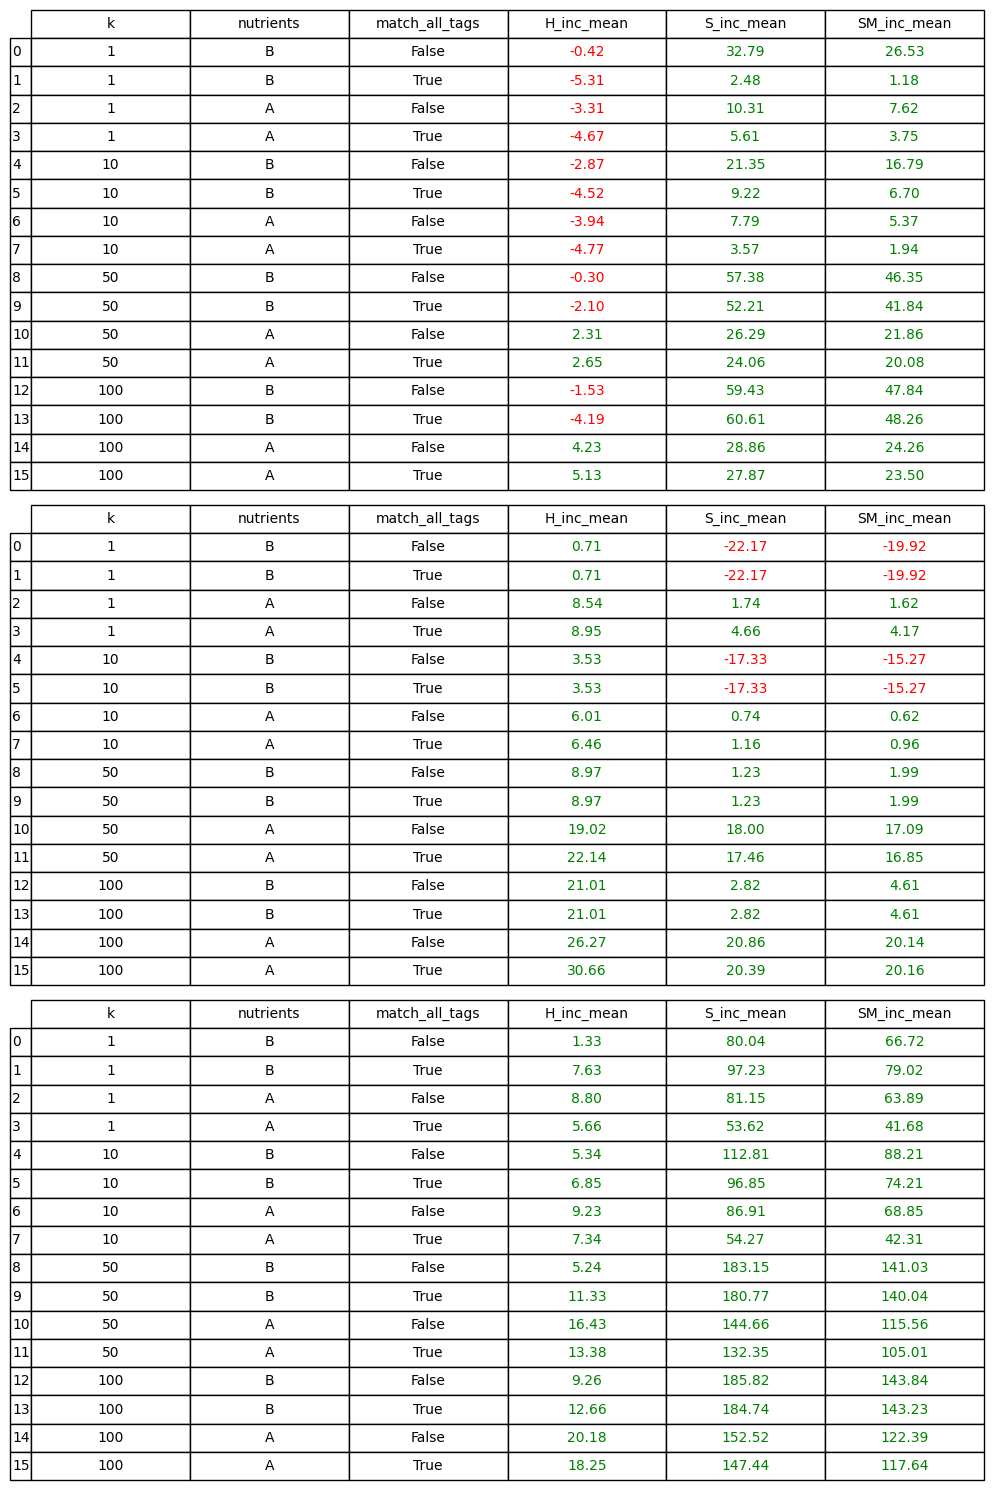

In [26]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Assumiamo che medie_high_who_score, medie_sustainability_label_1 e medie_sustainability_label_2 siano i DataFrame


# Funzione per abbreviare i titoli delle colonne
def abbreviate_column_names(df):
    abbreviations = {'healthiness_increment_mean': 'H_inc_mean',
                     'sustainability_increment_mean': 'S_inc_mean',
                     'sustainameal_score_increment_mean': 'SM_inc_mean'}
    return df.rename(columns=abbreviations)

# Applica l'abbreviazione ai nomi delle colonne per ogni DataFrame
medie_high_who_score = abbreviate_column_names(medie_high_who_score)
medie_sustainability_label_1 = abbreviate_column_names(medie_sustainability_label_1)
medie_sustainability_label_2 = abbreviate_column_names(medie_sustainability_label_2)

nutrients_A = ['calories [cal]', 'totalFat [g]', 'sodium [mg]', 'dietaryFiber [g]', 'sugars [g]', 'protein [g]']
nutrients_B = ['calories [cal]', 'totalFat [g]', 'saturatedFat [g]', 'cholesterol [mg]', 'sodium [mg]', 'dietaryFiber [g]', 'sugars [g]', 'protein [g]']

# Funzione per sostituire la stringa dei nutrienti con 'A' o 'B'
def replace_nutrients(nutrient_string):
    if nutrient_string == ', '.join(nutrients_A):
        return 'A'
    elif nutrient_string == ', '.join(nutrients_B):
        return 'B'
    else:
        return 'Unknown'

# Applicazione della funzione di sostituzione ai DataFrame
medie_high_who_score['nutrients'] = medie_high_who_score['nutrients'].apply(replace_nutrients)
medie_sustainability_label_1['nutrients'] = medie_sustainability_label_1['nutrients'].apply(replace_nutrients)
medie_sustainability_label_2['nutrients'] = medie_sustainability_label_2['nutrients'].apply(replace_nutrients)

# Funzione per colorare i valori in base al segno
def color_negative_red_positive_green(value):
    if value < 0:
        return 'red'
    elif value > 0:
        return 'green'
    else:
        return 'black'

# Funzione per colorare i valori in base al segno e arrotondare i numeri
def apply_formatting(tbl, df):
    for (i, j), cell in tbl.get_celld().items():
        if j < 2 or i == 0:  # Salta le prime due colonne e l'intestazione
            continue
        val = cell.get_text().get_text()
        try:
            num = float(val)
            cell.get_text().set_text(f'{num:.2f}')
            cell.get_text().set_color('green' if num > 0 else 'red' if num < 0 else 'black')
        except ValueError:
            pass  # Non è un numero, non fare nulla

# Crea una figura per contenere le tabelle
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Disegna le tabelle su ogni subplot e applica la formattazione
for ax, df in zip(axs.flat, [medie_high_who_score, medie_sustainability_label_1, medie_sustainability_label_2]):
    ax.axis('off')
    tbl = table(ax, df, loc='center', cellLoc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)
    apply_formatting(tbl, df)  # Applica il colore e l'arrotondamento qui

plt.tight_layout()
plt.show()



In [27]:
# Salviamo i tre subset in file JSON
high_who_score_recipes.to_json('high_who_score_recipes.json', orient='records')
sustainability_label_1_recipes.to_json('sustainability_label_1_recipes.json', orient='records')
sustainability_label_2_recipes.to_json('sustainability_label_2_recipes.json', orient='records')